In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import networkx as nx
from sklearn.neighbors import kneighbors_graph
from scipy.linalg import eigh, eigvals
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import folium


################################     Prepare data    #########################################

In [2]:
# Load both CSV files into pandas DataFrames
devices_df = pd.read_csv('bilbao_sonometers.csv') # or download sonometers stations from 'sonometers.py'
data_df = pd.read_csv('bilbao_sonometers_data.csv') # or download sonometers data from 'sonometers_data.py'

# Merge the first DataFrame (data_df) with the location columns (longitude, latitude) from the second DataFrame (devices_df)
devices_subset = devices_df[['name', 'longitude', 'latitude']]
merged_df = pd.merge(data_df, devices_subset, on='name', how='left')

# Select only the desired columns:
# name, longitude, latitude, decibels, timestamp, day_name, holiday
final_df = merged_df[['name', 'longitude', 'latitude', 'decibels', 'timestamp', 'week_day', 'holiday']]

# Extract the date and hour from the timestamp
final_df = final_df.copy()
final_df.loc[:, 'date'] = pd.to_datetime(final_df['timestamp']).dt.date.apply(lambda x: x.strftime('%Y-%m-%d'))
final_df.loc[:, 'hour'] = pd.to_datetime(final_df['timestamp']).dt.hour.astype(str)
final_df = final_df[final_df['decibels'] >= 0]
final_df = final_df[final_df['decibels'] <= 140]
final_df.head()

,name,longitude,latitude,decibels,timestamp,week_day,holiday,date,hour
0,BI-RUI-023,-2.964940,43.280629,59.651,2024-11-01 00:00:52.350,4,1,2024-11-01,0
1,BI-RUI-BR5,-2.923117,43.261757,63.709,2024-11-01 00:00:52.350,4,1,2024-11-01,0
2,BI-RUI-P012,-2.915837,43.253675,68.200,2024-11-01 00:00:52.350,4,1,2024-11-01,0
3,BI-RUI-006,-2.925136,43.256697,83.009,2024-11-01 00:00:52.350,4,1,2024-11-01,0
4,BI-RUI-005,-2.921992,43.257555,72.161,2024-11-01 00:00:52.350,4,1,2024-11-01,0


In [3]:
# Detection of outliers using the interquartile range (IQR) method
Q1 = final_df['decibels'].quantile(0.25)
Q3 = final_df['decibels'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
outliers_iqr = final_df[(final_df['decibels'] < lower) | (final_df['decibels'] > upper)]

print(f"Outlier count (IQR): {len(outliers_iqr)}")
print(f"IQR: {IQR}")
print(f"Lower bound: {lower}, Upper bound: {upper}")
print(f"Outlier count (IQR): {len(outliers_iqr)}")

final_df['decibels'].describe()

Outlier count (IQR): 177080
IQR: 20.39999999999999
Lower bound: 15.100000000000016, Upper bound: 96.69999999999999
Outlier count (IQR): 177080


count    1.026789e+06
mean     4.980378e+01
std      2.415809e+01
min      0.000000e+00
25%      4.570000e+01
50%      5.840000e+01
75%      6.610000e+01
max      1.397000e+02
Name: decibels, dtype: float64

In [4]:
# Filter out the outliers of the IQR method
final_df = final_df[(final_df['decibels'] >= lower) & (final_df['decibels'] <= upper)]

In [5]:
final_df['decibels'].describe()

count    849709.000000
mean         59.884558
std          10.416413
min          15.200000
25%          53.012000
50%          61.122000
75%          67.395000
max          96.600000
Name: decibels, dtype: float64

In [6]:
def calculate_LAeq(decibel_values):
    """
    Calculates the LAeq (Equivalent Sound Pressure Level) from a series of decibel values.
    
    LAeq = 10 * log10(1/N * Σ(10^(Li/10)))
    where Li are the individual decibel values and N is the number of samples.
    
    Parameters:
        decibel_values: list or array of decibel values.
        
    Returns:
        LAeq rounded to two decimals.
    """
    if len(decibel_values) == 0:
        return np.nan
    
    # Convert decibel values to relative sound intensity
    intensities = 10 ** (np.array(decibel_values) / 10)
    
    # Calculate the average of the intensities
    avg_intensity = np.mean(intensities)
    
    # Convert back to decibels (LAeq)
    LAeq = 10 * np.log10(avg_intensity)
    
    return round(LAeq, 2)


# Group by name, date, and hour and calculate the LAeq for each group
df_LAeq_hourly = final_df.groupby(['timestamp','name', 'date', 'hour']).agg(
    LAeq=('decibels', calculate_LAeq),
    sample_count=('decibels', 'count'),
    longitude=('longitude', 'first'),
    latitude=('latitude', 'first'),
    week_day=('week_day', 'first'),
    holiday=('holiday', 'first')
    
).reset_index()

# Sort the results for better visualization
df_LAeq_hourly = df_LAeq_hourly.sort_values(['timestamp','date', 'hour', 'name'])

df_LAeq_hourly['datetime'] = pd.to_datetime(df_LAeq_hourly['date'] + ' ' + df_LAeq_hourly['hour'] + ':00:00')

print(f"LAeq was calculated for {len(df_LAeq_hourly)} combinations of device-hour-date")

len(df_LAeq_hourly['name'].unique())

LAeq was calculated for 849709 combinations of device-hour-date


67

In [7]:
df_LAeq_hourly['LAeq'].describe()

count    849709.000000
mean         59.884559
std          10.416418
min          15.200000
25%          53.010000
50%          61.120000
75%          67.400000
max          96.600000
Name: LAeq, dtype: float64

############################     Construction and analysis of graphs    ############################

In [8]:
# Construction of two graph variants (geographic (Geo) and statistical (LAeq)) that connect each node with its k nearest neighbors
def construct_geo_LAeq_graphs(df, k):
    """
    Constructs two graphs connecting each node to its k nearest neighbors:
    G_Geo: based on geographic coordinates (latitude, longitude)
    G_LAeq: based on LAeq features (mean and standard deviation)
    
    Args:
        df: DataFrame with the sonometer data
        k: Number of nearest neighbors to connect (default 5)
    
    Returns:
        G_Geo: Graph based on geographic coordinates
        G_LAeq: Graph based on LAeq measurements
        node_mapping: Mapping of node names to IDs (common for both graphs)
    """
    from sklearn.neighbors import kneighbors_graph
   
    
    # Extract unique data for each node (for geographic coordinates)
    geo_node_data = df[['name', 'longitude', 'latitude']].drop_duplicates().set_index('name')
    
    # Calculate the mean and standard deviation of LAeq for each node
    LAeq_stats = df.groupby('name')['LAeq'].agg(['mean', 'std']).reset_index()
    LAeq_stats.columns = ['name', 'LAeq_mean', 'LAeq_std']
    LAeq_node_data = LAeq_stats.set_index('name')
    
    # Fill NaN in case any node has only one measurement 
    LAeq_node_data['LAeq_std'] = LAeq_node_data['LAeq_std'].fillna(0)
    
    # List of node names
    common_nodes = sorted(set(geo_node_data.index) & set(LAeq_node_data.index))
    n = len(common_nodes)
    
    # Filter to keep only common nodes
    geo_node_data = geo_node_data.loc[common_nodes]
    LAeq_node_data = LAeq_node_data.loc[common_nodes]
    
    # Create graphs
    G_Geo = nx.Graph()
    G_LAeq = nx.Graph()
    
    # Create mapping of names to node IDs (common for both graphs)
    node_mapping = {node: i for i, node in enumerate(common_nodes)}
    
    # Add nodes to both graphs with their attributes
    for i, node in enumerate(common_nodes):
        # Add node to the geographic graph
        G_Geo.add_node(i,
                      name=node,
                      longitude=geo_node_data.loc[node, 'longitude'],
                     latitude=geo_node_data.loc[node, 'latitude'])
        
        # Add node to the LAeq graph
        G_LAeq.add_node(i,
                       name=node,
                       LAeq_mean=LAeq_node_data.loc[node, 'LAeq_mean'],
                      LAeq_std=LAeq_node_data.loc[node, 'LAeq_std'],
                      longitude=geo_node_data.loc[node, 'longitude'],
                      latitude=geo_node_data.loc[node, 'latitude'])
    
    # Construction of edges for G_Geo based on coordinates
    geo_coords = geo_node_data[['latitude', 'longitude']].values
    
    # Use kneighbors_graph instead of distance_matrix
    geo_adj_matrix = kneighbors_graph(geo_coords, k, mode='connectivity', include_self=False)
    
    # Create edges from the adjacency matrix
    geo_adj_coo = geo_adj_matrix.tocoo()
    for src, dst in zip(geo_adj_coo.row, geo_adj_coo.col):
        G_Geo.add_edge(src, dst, weight=1)
    
    # Construction of edges for G_LAeq based on LAeq features
    LAeq_features = LAeq_node_data[['LAeq_mean', 'LAeq_std']].values
    
    # Use kneighbors_graph instead of distance_matrix
    LAeq_adj_matrix = kneighbors_graph(LAeq_features, k, mode='connectivity', include_self=False)
    
    # Create edges from the adjacency matrix
    LAeq_adj_coo = LAeq_adj_matrix.tocoo()
    for src, dst in zip(LAeq_adj_coo.row, LAeq_adj_coo.col):
        G_LAeq.add_edge(src, dst, weight=1)
    
    return G_Geo, G_LAeq, node_mapping

In [9]:
# Evaluate "optimal" k considering both graphs
def eval_geo_LAeq_metrics(df, ks):
    """
    For each k in ks:
      1) constructs G_Geo and G_LAeq
      2) calculates the number of connected components and 
         average clustering coefficient for each graph
    Returns a DataFrame with the metrics.
    """
    records = []
    for k in ks:
        # construct both graphs
        G_geo, G_laeq, _ = construct_geo_LAeq_graphs(df, k)
        
        # metrics for G_geo
        comps_geo      = nx.number_connected_components(G_geo)
        clustering_geo = nx.average_clustering(G_geo)
        
        # metrics for G_laeq
        comps_laeq      = nx.number_connected_components(G_laeq)
        clustering_laeq = nx.average_clustering(G_laeq)
        
        records.append({
            'k': k,
            'components_geo': comps_geo,
            'avg_clustering_geo': clustering_geo,
            'components_laeq': comps_laeq,
            'avg_clustering_laeq': clustering_laeq
        })
        
    return pd.DataFrame(records)

ks = range(1, 10)  
metrics_df = eval_geo_LAeq_metrics(df_LAeq_hourly, ks)

print(metrics_df)


   k  components_geo  avg_clustering_geo  components_laeq  avg_clustering_laeq
0  1              21            0.000000               15             0.000000
1  2               4            0.500000                3             0.474627
2  3               3            0.638024                1             0.490050
3  4               2            0.649621                1             0.539801
4  5               2            0.680398                1             0.560637
5  6               1            0.682177                1             0.593172
6  7               1            0.672195                1             0.607537
7  8               1            0.673109                1             0.631169
8  9               1            0.688132                1             0.653236


In [10]:
G_Geo, _, node_mapping = construct_geo_LAeq_graphs(df_LAeq_hourly, k=6)
_, G_LAeq, node_mapping = construct_geo_LAeq_graphs(df_LAeq_hourly, k=3)

In [11]:
expected_max_edges = 67 * 4 / 2  # k * n / 2
print(f"Expected max edges (no overlap): {expected_max_edges}")
print(f"Actual edges in G_Geo: {G_Geo.number_of_edges()}")
print(f"Actual edges in G_LAeq: {G_LAeq.number_of_edges()}")
print(" ")

print(f"Number of nodes in G_Geo: {len(G_Geo.nodes)}")
print(f"Number of nodes in G_LAeq: {len(G_LAeq.nodes)}")
print(f"Number of edges in G_Geo: {len(G_Geo.edges)}")
print(f"Number of edges in G_LAeq: {len(G_LAeq.edges)}")

Expected max edges (no overlap): 134.0
Actual edges in G_Geo: 271
Actual edges in G_LAeq: 140
 
Number of nodes in G_Geo: 67
Number of nodes in G_LAeq: 67
Number of edges in G_Geo: 271
Number of edges in G_LAeq: 140


In [12]:
# Analyze the connectivity of the FL network
def analyze_network(G):
    """
    Analyzes the connectivity of the FL network by:
    - Plotting node degrees.
    - Computing and plotting the eigenvector corresponding to the second smallest eigenvalue of the Laplacian matrix.
    """
    
    degrees = [G.degree(n) for n in G.nodes()]
    
    # Compute Laplacian matrix

    L = nx.laplacian_matrix(G).toarray()
    
    # Compute eigenvalues and eigenvectors    
 
    eigvals, eigvecs = eigh(L) 

    if len(eigvals) > 1:
        # Second smallest eigenvalue and corresponding eigenvector
        v2 = eigvecs[:, 1]

        # Plot node degrees
        plt.figure(figsize=(10, 5))
        plt.bar(range(1, len(degrees) + 1), degrees)
        plt.xlabel("Node Index")
        plt.ylabel("Degree")
        plt.title("Node Degrees")
        plt.show()

        # Plot eigenvector entries
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(v2) + 1), v2, marker="o")
        plt.xlabel("Node Index")
        plt.ylabel("Eigenvector Entry")
        plt.title("Fiedler Eigenvector")
        plt.show()
    else:
        print("Not enough connected nodes to compute the second smallest eigenvalue.")


Analyzing network structure for geo-based graph:
-------------------------------------------------
Graph G_Geo 


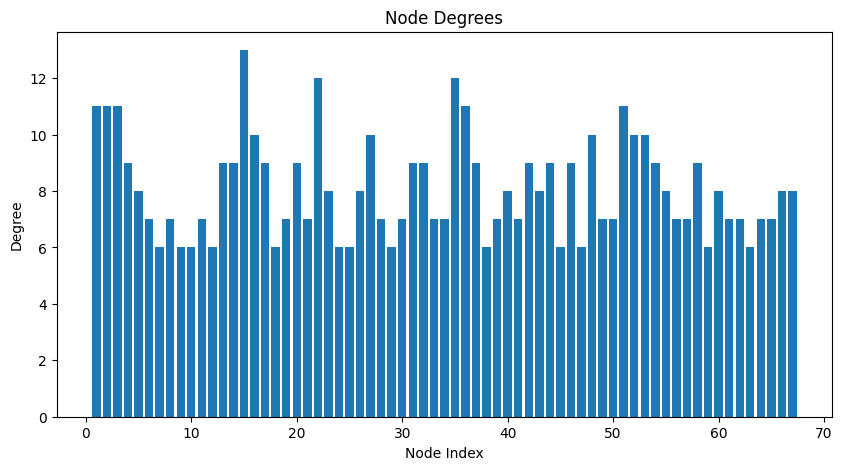

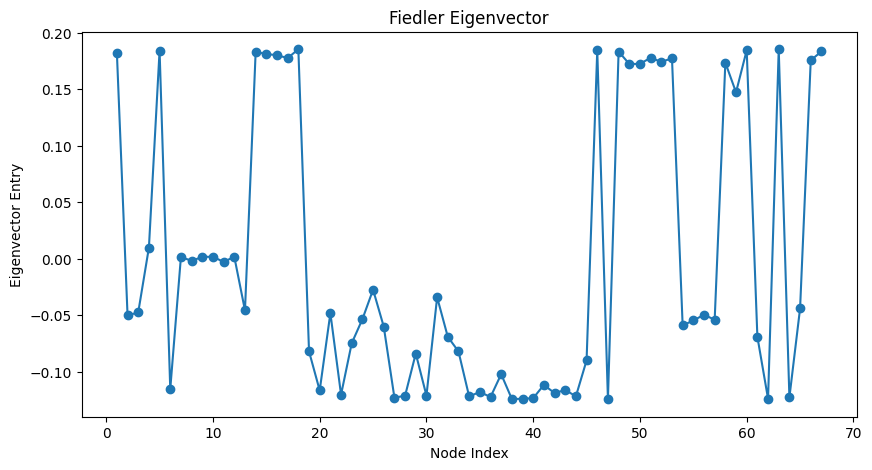

-------------------------------------------------
Graph  G_LAeq 


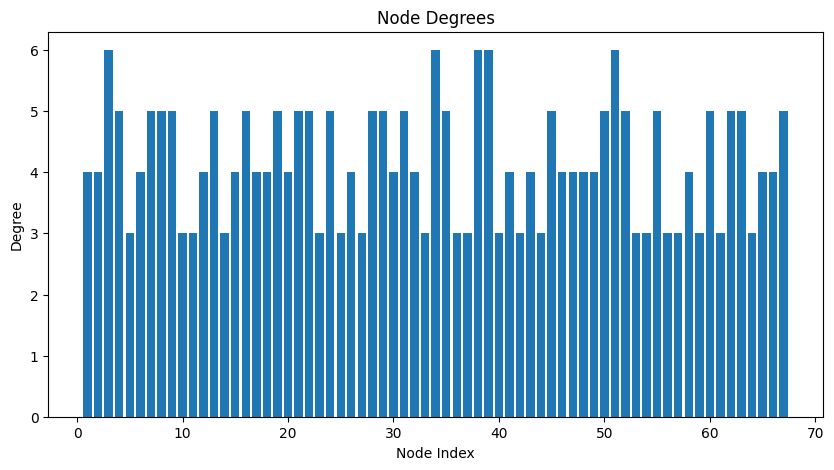

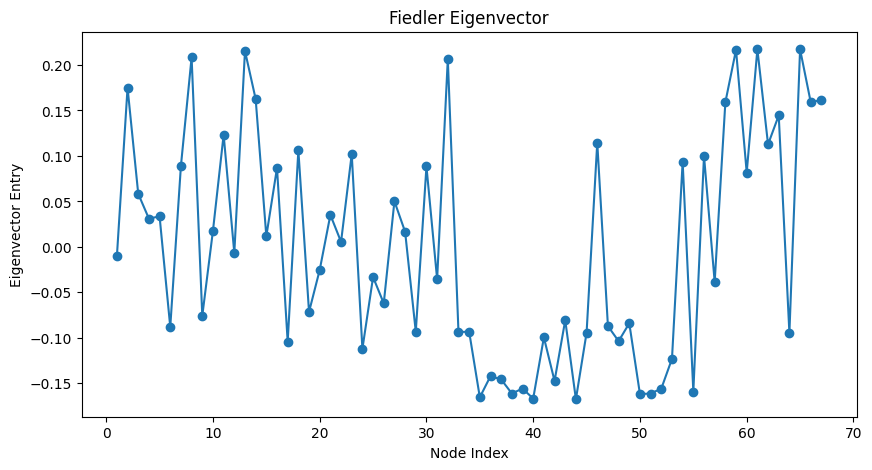

In [13]:
print("Analyzing network structure for geo-based graph:")

print("-------------------------------------------------")
print('Graph G_Geo ')
analyze_network(G_Geo)
print("-------------------------------------------------")

print('Graph  G_LAeq ')
analyze_network(G_LAeq)

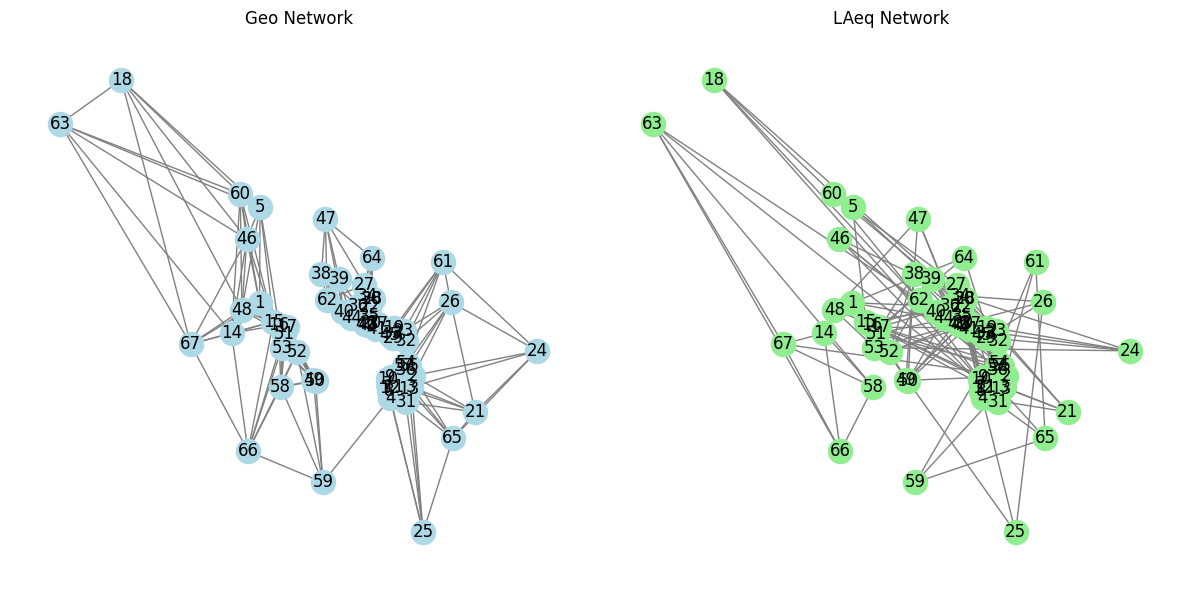

In [14]:
# Relabel nodes for both networks so that they start from 1 instead of 0
G_Geo_relabel = nx.relabel_nodes(G_Geo, {i: i+1 for i in G_Geo.nodes()})
G_stat_relabel = nx.relabel_nodes(G_LAeq, {i: i+1 for i in G_LAeq.nodes()})

# Create a common position dictionary for both graphs
common_pos = {
    i+1: (G_Geo.nodes[i]['longitude'], G_Geo.nodes[i]['latitude'])
    for i in G_Geo.nodes()
}

# Plot the two graphs side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
nx.draw(G_Geo_relabel, pos=common_pos, ax=ax1, with_labels=True,
        node_color='lightblue', edge_color='gray')
ax1.set_title("Geo Network")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

nx.draw(G_stat_relabel, pos=common_pos, ax=ax2, with_labels=True,
        node_color='lightgreen', edge_color='gray')
ax2.set_title("LAeq Network")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")

plt.tight_layout()
plt.show()


###########      Analyze existence of clusters in the graph   #########


--- Cluster analysis for G_LAeq ---


/home/jp/Documentos/Python/gtv_venv/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


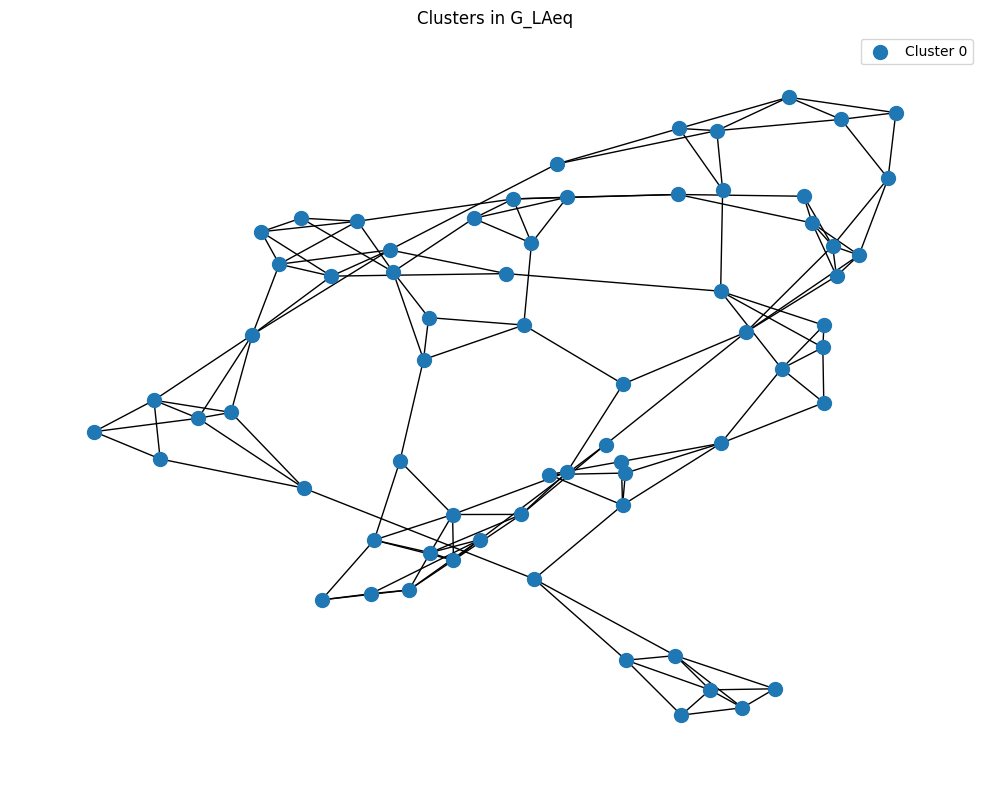

Cluster 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]
Cluster 1: []
Cluster 2: []

--- Cluster analysis for G_Geo ---


/home/jp/Documentos/Python/gtv_venv/lib/python3.12/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


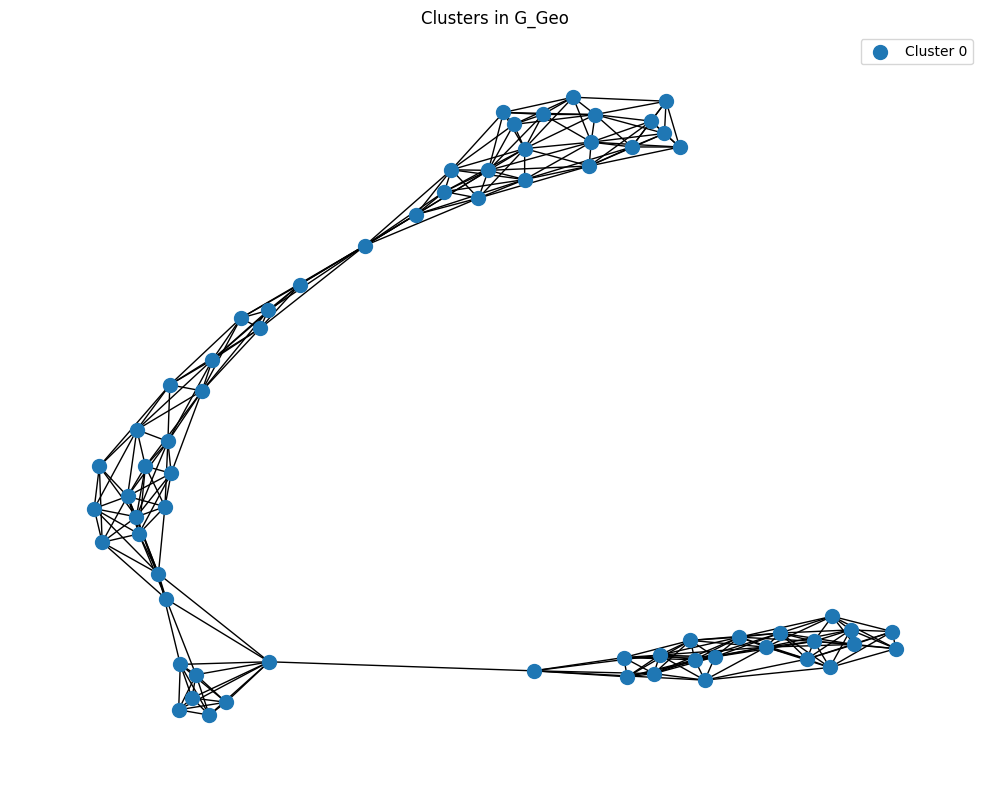

Cluster 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66]
Cluster 1: []
Cluster 2: []


In [15]:
# Analyze existence of clusters in the graph
def analyze_clusters(G, name, n_components, k, seed=42):
    """
    Analyze a graph to detect and visualize clusters based on nodes' GMM features.
    
    Args:
        G: NetworkX graph
        name: Graph name for visualization
        n_components: Number of components for GMM
        k: Number of clusters for K-means
        seed: Random seed for reproducibility
    
    Returns:
        cluster_labels: Dictionary mapping node to its assigned cluster
    """
    print(f"\n--- Cluster analysis for {name} ---")

    # Fit each node to the GMM model and extract model parameters
    for node in G.nodes():
        if 'X' in G.nodes[node]:
            node_X = G.nodes[node]['X']
        elif 'pos' in G.nodes[node]:
            node_X = np.array(G.nodes[node]['pos']).reshape(1, -1)
        else:
            node_X = np.eye(n_components)

        if node_X.ndim == 1:
            node_X = node_X.reshape(-1, 1)

        gmm = GaussianMixture(n_components=n_components, random_state=seed)
        gmm.fit(node_X)

        gmm_params = np.hstack([gmm.means_.ravel(), gmm.covariances_.ravel(), gmm.weights_])
        G.nodes[node]['gmm_params'] = gmm_params

    # Collect GMM parameters and fit K-Means
    gmm_params = np.array([G.nodes[node]['gmm_params'] for node in G.nodes()])
    kmeans = KMeans(n_clusters=k, random_state=seed, n_init=10)
    kmeans.fit(gmm_params)

    # Assign clusters
    cluster_labels = {node: int(label) for node, label in zip(G.nodes(), kmeans.labels_)}
    for node, lbl in cluster_labels.items():
        G.nodes[node]['cluster'] = lbl

    # Visualize clusters
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=seed)
    for cluster in range(k):
        nodes_in_cluster = [n for n, lbl in cluster_labels.items() if lbl == cluster]
        nx.draw_networkx_nodes(G, pos, nodelist=nodes_in_cluster,
                               node_color=f"C{cluster}", node_size=100,
                               label=f"Cluster {cluster}")
    nx.draw_networkx_edges(G, pos, alpha=1)
    if len(G.nodes()) <= 50:
        nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(f"Clusters in {name}")
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Print clusters
    for cluster in range(k):
        members = [n for n, lbl in cluster_labels.items() if lbl == cluster]
        print(f"Cluster {cluster}: {members}")

    return cluster_labels


n_components = 2  # Number of GMM components
k = 3             # Number of clusters
labels_laeq = analyze_clusters(G_LAeq, "G_LAeq", n_components, k)
labels_geo = analyze_clusters(G_Geo, "G_Geo", n_components, k)


<Figure size 2000x1200 with 0 Axes>

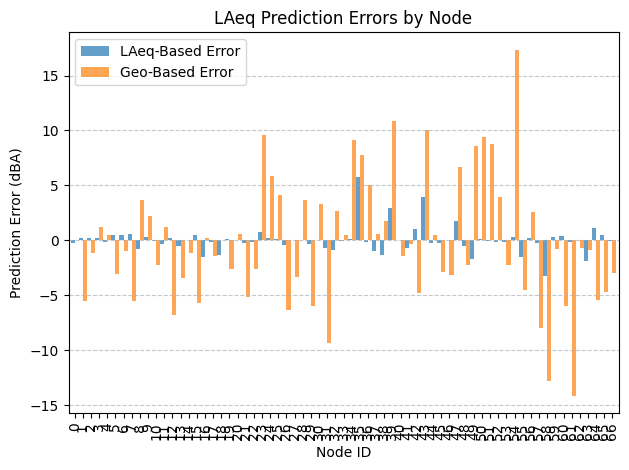

In [16]:
# Local averaging function
def local_averaging(G, node_mapping, df):
    """
    Implements a simple federated learning algorithm for a FL network represented by the input `G` which is a `networkx.Graph()` object.
    
    Each node predicts LAeq by averaging the values of its neighbors. Computes the actual average LAeq for
    each node. Computes and stores the prediction error for each node.
    
    Parameters:
    G (networkx.Graph): The FL network graph where each node represents a sonometer.
    node_mapping (dict): Mapping between node names and node IDs.
    df (pandas.DataFrame): DataFrame containing the LAeq measurements.
    
    Returns:
    dict: A dictionary where keys are node IDs and values are prediction errors.
    """
    prediction_errors = {}
    
    # Create a dictionary to map node IDs to their LAeq values
    node_LAeq = {}
    for node_name, node_id in node_mapping.items():
        node_df = df[df['name'] == node_name]
        if not node_df.empty:
            node_LAeq[node_id] = node_df['LAeq'].values
    
    # Calculate prediction errors
    for i in G.nodes():
        # Get neighbors of current node
        neighbors = list(G.neighbors(i))        

        if i not in node_LAeq:
            continue
        
        # Calculate prediction based on neighbors' data
        if neighbors:
            valid_neighbors = [j for j in neighbors if j in node_LAeq]
            if valid_neighbors:
                avg_LAeq_pred = np.mean([np.mean(node_LAeq[j]) for j in valid_neighbors])
            else:
                avg_LAeq_pred = np.mean(node_LAeq[i])
        else:
            avg_LAeq_pred = np.mean(node_LAeq[i])

        avg_LAeq_actual = np.mean(node_LAeq[i])

        prediction_errors[i] = avg_LAeq_pred - avg_LAeq_actual
    
    return prediction_errors


# Compute prediction errors for both networks
prediction_errors_geo = local_averaging(G_Geo, node_mapping, df_LAeq_hourly)
prediction_errors_stat = local_averaging(G_LAeq, node_mapping, df_LAeq_hourly)

results_df = pd.DataFrame({
    "LAeq-Based Error": [prediction_errors_stat.get(i, np.nan) for i in G_LAeq.nodes()],
    "Geo-Based Error": [prediction_errors_geo.get(i, np.nan) for i in G_Geo.nodes()] 
}, index=list(G_LAeq.nodes()))


plt.figure(figsize=(20, 12))
results_df.plot(kind='bar', width=1.0, alpha=0.7)
plt.title('LAeq Prediction Errors by Node')
plt.xlabel('Node ID')
plt.ylabel('Prediction Error (dBA)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [17]:
# Compute metrics
mae = results_df.abs().mean()
rmse = np.sqrt((results_df**2).mean())

metrics_df = pd.DataFrame({
    'MAE': mae,
    'RMSE': rmse
})

metrics_df = metrics_df.round(3)


print("Prediction Error Comparison by Graph Type:")
print(metrics_df)


Prediction Error Comparison by Graph Type:
                    MAE   RMSE
LAeq-Based Error  0.660  1.193
Geo-Based Error   4.374  5.715


**Prediction Error Comparison by Graph Type:**

G_Geo (k=5)  
G_LAeq (k=3)  

| Graph Type             | MAE   | RMSE  |
|------------------------|-------|--------|
| LAeq-Based Error       | 0.660 | 1.193  |
| Geo-Based Error        | 4.504 | 5.855  |

**Prediction Error Comparison by Graph Type:**

G_Geo (k=6)  
G_LAeq (k=4)  

| Graph Type             | MAE   | RMSE  |
|------------------------|-------|--------|
| LAeq-Based Error       | 0.768 | 1.490  |
| Geo-Based Error        | 4.374 | 5.715  |

**Prediction Error Comparison by Graph Type:**

G_Geo (k=7)  
G_LAeq (k=5)  

| Graph Type             | MAE   | RMSE  |
|------------------------|-------|--------|
| LAeq-Based Error       | 0.776 | 1.364  |
| Geo-Based Error        | 4.493 | 5.801  |

Conclusion:
The 'G_LAeq' graph is better at propagating useful information between nodes trying to predict LAeq.

In [18]:
df_LAeq_hourly.head()

,timestamp,name,date,hour,LAeq,sample_count,longitude,latitude,week_day,holiday,datetime
0,2024-11-01 00:00:52.350,BI-RUI-004,2024-11-01,0,75.79,1,-2.921691,43.258396,4,1,2024-11-01
1,2024-11-01 00:00:52.350,BI-RUI-005,2024-11-01,0,72.16,1,-2.921992,43.257555,4,1,2024-11-01
2,2024-11-01 00:00:52.350,BI-RUI-006,2024-11-01,0,83.01,1,-2.925136,43.256697,4,1,2024-11-01
3,2024-11-01 00:00:52.350,BI-RUI-017,2024-11-01,0,81.79,1,-2.922400,43.257373,4,1,2024-11-01
4,2024-11-01 00:00:52.350,BI-RUI-023,2024-11-01,0,59.65,1,-2.964940,43.280629,4,1,2024-11-01


In [19]:
# Functions to prepare cyclical features
def create_cyclical_features(df):
    """
    Creates cyclical features for hour and day of the week
    """
    # Cyclical encoding for hours (0-23)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'].astype(int) / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'].astype(int) / 24)
    
    # Cyclical encoding for days of the week (0-6)
    df['weekday_sin'] = np.sin(2 * np.pi * df['week_day'].astype(int) / 7)
    df['weekday_cos'] = np.cos(2 * np.pi * df['week_day'].astype(int) / 7)
    return df

# Function to create time series features (lags)
def create_lag_features(df):
    """
    Creates time lag features for each node
    """  
    # Sort by node and COMPLETE timestamp to ensure correct time sequence
    df = df.sort_values(['name', 'timestamp']) 

    # Initialize lag columns in the main dataframe
    lag_columns = ['LAeq_lag1', 'LAeq_lag2', 'LAeq_lag3', 'LAeq_lag24', 'LAeq_delta']
    for col in lag_columns:
        df[col] = np.nan
    
    # Create lag features
    for node in df['name'].unique():
        # Get indices of the current node (after correct sorting)
        node_indices = df[df['name'] == node].index
        
        # Create LAeq lagged by 1, 2, 3, and 24 hours for this node
        df.loc[node_indices, 'LAeq_lag1'] = df.loc[node_indices, 'LAeq'].shift(1)
        df.loc[node_indices, 'LAeq_lag2'] = df.loc[node_indices, 'LAeq'].shift(2)
        df.loc[node_indices, 'LAeq_lag3'] = df.loc[node_indices, 'LAeq'].shift(3)
        df.loc[node_indices, 'LAeq_lag24'] = df.loc[node_indices, 'LAeq'].shift(24) 
        
        # Create delta (change with respect to the previous hour)
        df.loc[node_indices, 'LAeq_delta'] = df.loc[node_indices, 'LAeq'] - df.loc[node_indices, 'LAeq_lag1']
    
    return df

In [20]:
df = df_LAeq_hourly
# Sort the DataFrame by 'datetime'
df['datetime'] = pd.to_datetime(df['datetime'])

print("Preparing cyclical features...")
df = create_cyclical_features(df)
    
print("Creating time lag features...")
df = create_lag_features(df)
df = df.dropna()

df.head()


Preparing cyclical features...
Creating time lag features...


,timestamp,name,date,hour,LAeq,sample_count,longitude,latitude,week_day,holiday,datetime,hour_sin,hour_cos,weekday_sin,weekday_cos,LAeq_lag1,LAeq_lag2,LAeq_lag3,LAeq_lag24,LAeq_delta
1487,2024-11-01 06:01:10.473,BI-RUI-001,2024-11-01,6,67.39,1,-2.944465,43.263875,4,1,2024-11-01 06:00:00,1.000000,6.123234e-17,-0.433884,-0.900969,68.09,70.15,74.34,64.34,-0.70
1542,2024-11-01 06:15:58.507,BI-RUI-001,2024-11-01,6,73.73,1,-2.944465,43.263875,4,1,2024-11-01 06:00:00,1.000000,6.123234e-17,-0.433884,-0.900969,67.39,68.09,70.15,65.90,6.34
1604,2024-11-01 06:30:56.443,BI-RUI-001,2024-11-01,6,67.44,1,-2.944465,43.263875,4,1,2024-11-01 06:00:00,1.000000,6.123234e-17,-0.433884,-0.900969,73.73,67.39,68.09,67.15,-6.29
1665,2024-11-01 06:46:06.040,BI-RUI-001,2024-11-01,6,63.67,1,-2.944465,43.263875,4,1,2024-11-01 06:00:00,1.000000,6.123234e-17,-0.433884,-0.900969,67.44,73.73,67.39,70.82,-3.77
1727,2024-11-01 07:00:59.480,BI-RUI-001,2024-11-01,7,58.42,1,-2.944465,43.263875,4,1,2024-11-01 07:00:00,0.965926,-2.588190e-01,-0.433884,-0.900969,63.67,67.44,73.73,74.86,-5.25


In [21]:
cols = ['hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos',
        'LAeq_lag1', 'LAeq_lag2', 'LAeq_lag3', 'LAeq_lag24', 'LAeq_delta', 'holiday']

df[cols].describe()

,hour_sin,hour_cos,weekday_sin,weekday_cos,LAeq_lag1,LAeq_lag2,LAeq_lag3,LAeq_lag24,LAeq_delta,holiday
count,848101.000000,8.481010e+05,848101.000000,848101.000000,848101.000000,848101.000000,848101.000000,848101.000000,848101.000000,848101.000000
mean,-0.000226,-1.375756e-03,-0.007978,-0.002046,59.883021,59.882879,59.882620,59.884732,0.000096,0.031686
std,0.707927,7.062854e-01,0.707692,0.706474,10.414475,10.414600,10.414813,10.416788,4.755312,0.175163
min,-1.000000,-1.000000e+00,-0.974928,-0.900969,15.200000,15.200000,15.200000,15.200000,-80.700000,0.000000
25%,-0.707107,-7.071068e-01,-0.781831,-0.900969,53.020000,53.010000,53.010000,53.000000,-1.300000,0.000000
50%,0.000000,-1.836970e-16,0.000000,-0.222521,61.130000,61.130000,61.120000,61.120000,0.000000,0.000000
75%,0.707107,7.071068e-01,0.781831,0.623490,67.390000,67.390000,67.390000,67.400000,1.310000,0.000000
max,1.000000,1.000000e+00,0.974928,1.000000,96.600000,96.600000,96.600000,96.600000,81.200000,1.000000


In [22]:
# Prepare data for federated learning
def load_node_data(df, G, test_size=0.2, random_state=42):
    """
    Prepares the data from each node for federated learning and loads it into the graph.
  
    """  
    reverse_mapping = {node_id: node_name for node_name, node_id in node_mapping.items()}

    for node_id, node_name in reverse_mapping.items():
        node_df = df[df['name'] == node_name].copy()
        
        if node_df.empty:
            print(f"Warning: No data found for node {node_name}.")
            continue        

        node_df = node_df.dropna(subset=['LAeq_lag1', 'LAeq_lag2', 'LAeq_lag3', 'LAeq_lag24'])

        if len(node_df) > 0:
            features = [
                'LAeq_lag1', 'LAeq_lag2', 'LAeq_lag3', 'LAeq_lag24', 'LAeq_delta',
                'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos', 'holiday'
            ]
            # Check if all features are present
            for feature in features:
                if feature not in node_df.columns:
                    print(f"Warning: Missing column {feature} for node {node_name}. Filling with 0.")
                    node_df[feature] = 0

            X = node_df[features].values
            y = node_df['LAeq'].shift(-1).dropna().values
            X = X[:-1]

            if np.isinf(X).any():
                print(f"Warning: Infinite values in node {node_name}. Replacing them with NaN.")
                X = np.where(np.isinf(X), np.nan, X)
            X = np.nan_to_num(X, nan=0.0)
            
            scaler = MinMaxScaler()
            X_scaled = scaler.fit_transform(X)
            datetime_iso = node_df['datetime'].iloc[:-1].dt.strftime('%Y-%m-%dT%H:%M:%S').tolist()
            latitude = node_df['latitude'].iloc[0]
            longitude = node_df['longitude'].iloc[0]

            # Split data into training and validation
            X_train, X_val, y_train, y_val = train_test_split(
                X_scaled, y, test_size=test_size, random_state=random_state
            )

            n_features = X_scaled.shape[1] if len(X_scaled.shape) > 1 else 1

            # Update the node in the graph
            lat = latitude
            lon = longitude
            coord = (lat, lon) if lat is not None and lon is not None else None

            G.nodes[node_id].update({
                'name': node_name,
                'X_train': X_train,
                'y_train': y_train,
                'X_val': X_val,
                'y_val': y_val,
                'weights': np.zeros((n_features, 1)),
                'feature_names': features,
                'datetime': datetime_iso,
                'coord': coord
            })
        else:
            print(f"Warning: After dropna, no data remains for node {node_name}.")
    
    missing_nodes = set(G.nodes()) - set(reverse_mapping.keys())
    print(f"Nodes not in node_data: {missing_nodes}")
    print(f"Data prepared for {len(G.nodes()) - len(missing_nodes)} nodes.")
    print("The graph is connected:", nx.is_connected(G))
    
    return G


Graph G_LAeq

In [23]:
# Prepare G_LAeq graph with node data
G_LAeq= load_node_data(df, G_LAeq)# 
G_Geo = load_node_data(df, G_Geo)# 

Nodes not in node_data: set()
Data prepared for 67 nodes.
The graph is connected: True
Nodes not in node_data: set()
Data prepared for 67 nodes.
The graph is connected: True


In [24]:
# Function to visualize the graph on an interactive Folium map
def visualize_graph_on_map(G):
    """
    Creates an interactive Folium map to visualize the graph.
    
    Args:
        G (networkx.Graph): Graph with coordinates stored in the attributes of each node.
    
    Returns:
        folium.Map: Interactive map with the graph visualized.
    """
    # Calculate the center of the map based on the existing coordinates
    lat_sum, lon_sum, count = 0, 0, 0
    for node, data in G.nodes(data=True):
        coord = data.get('coord')
        if coord and None not in coord:
            lat_sum += coord[0]
            lon_sum += coord[1]
            count += 1
    
    # Use the calculated center or default coordinates of Bilbao if no data is available
    if count > 0:
        center_lat, center_lon = lat_sum / count, lon_sum / count
    else:
        center_lat, center_lon = 43.2630, -2.9350  # Default coordinates of Bilbao
    
    # Create a map centered on the data
    m = folium.Map(location=[center_lat, center_lon], zoom_start=14, 
                  tiles='OpenStreetMap')    
    
    # Add nodes to the map
    for node, data in G.nodes(data=True):
        coord = data.get('coord')
        if coord and None not in coord:
            lat, lon = coord[0], coord[1]
            popup_text = f"Node: {node}"
            
            folium.CircleMarker(
                location=[lat, lon],
                radius=5,
                popup=popup_text,
                color='blue',
                fill=True,
                fill_color='blue',
                fill_opacity=0.7
            ).add_to(m)
    
    # Add edges to the map
    for u, v, data in G.edges(data=True):
        if G.nodes[u].get('coord') and G.nodes[v].get('coord'):
            source_coord = G.nodes[u]['coord']
            target_coord = G.nodes[v]['coord']
            
            if None not in source_coord and None not in target_coord:
                folium.PolyLine(
                    locations=[[source_coord[0], source_coord[1]], 
                              [target_coord[0], target_coord[1]]],
                    color='gray',
                    weight=2,
                    opacity=0.7
                ).add_to(m)
    
    return m


map = visualize_graph_on_map(G_LAeq) 
map


In [25]:
# Check shape and mean of X_train for a sample node
print("Checking input data:")
sample_node_id = list(G_LAeq.nodes())[0]
if 'X_train' in G_LAeq.nodes[sample_node_id]:
     X_sample = G_LAeq.nodes[sample_node_id]['X_train']
     print(f"Node {sample_node_id} - Shape X_train: {X_sample.shape}")
     print(f"Node {sample_node_id} - Mean X_train:\n{np.mean(X_sample, axis=0)}")
     print(f"Node {sample_node_id} - Std Dev X_train:\n{np.std(X_sample, axis=0)}")
else:
     print(f"Sample node {sample_node_id} does not have X_train.")

Checking input data:
Node 0 - Shape X_train: (11528, 10)
Node 0 - Mean X_train:
[0.50226263 0.50259954 0.5028295  0.50286908 0.47629533 0.50339172
 0.49989348 0.49716585 0.47487368 0.03122831]
Node 0 - Std Dev X_train:
[0.15858565 0.15865454 0.158529   0.15919327 0.072563   0.3538787
 0.35321148 0.36324246 0.37134612 0.1739342 ]


################################     Federating Learning    #########################################

In [26]:
def FedGD_Linear(graph, alpha, eta, max_iter):    
    """
    Perform Federated Gradient Descent (FedGD) on a graph G for a linear model.

    This function iteratively updates local model weights for each node in the graph 
    using Mean Squared Error (MSE) gradient descent. It also incorporates a graph-based 
    penalty term to encourage similar weights among neighboring nodes.

    Parameters
    ----------
    G : networkx.Graph
        A graph where each node represents a dataset and contains:
        - 'X_train' : numpy.ndarray of shape (m_i, d), local training features
        - 'y_train' : numpy.ndarray of shape (m_i,), local training targets
        - 'w'       : numpy.ndarray of shape (d, 1), initialized model weights (randomized)
    alpha : float, optional
        Regularization parameter for the neighbor penalty (default is 1.0).
    eta : float, optional
        Learning rate for gradient updates (default is 0.001).
    max_iter : int, optional
        Number of gradient descent iterations (default is 100).

    Returns
    -------
    G : networkx.Graph
        The updated graph with optimized model weights for each node.
    """
    # Define the random seed
    np.random.seed(42)
    
    # Deep copy the input graph
    G = copy.deepcopy(graph)
    
    # Initialize weights
    for node in G.nodes():
        d = graph.nodes[node]['X_train'].shape[1]
        w_init = np.random.uniform(low=-1.0, high=1.0, size=d)
        G.nodes[node]['w'] = w_init

    # Initialize history to track MSE
    history = {'iteration': [], 'mse': []}
    
    for iter_num in range(max_iter):
        # Temporary dict to store newly computed weights before synchronization
        w_new = {}

        # Compute updates for each node
        for node in G.nodes():
            # Extract the current local weight
            w_i_k = G.nodes[node]['w']

            # Local training data
            X_train = G.nodes[node]['X_train']
            y_train = G.nodes[node]['y_train']
            
            # (I) Local gradient (MSE derivative)  
            m_i = X_train.shape[0]  # number of local samples
            residual = y_train - X_train @ w_i_k   # shape (m_i,)
            # MSE derivative wrt w is -2 * X.T * (y - Xw)
            grad_local = (2.0 / m_i) * (X_train.T @ residual)            

            # (II) Graph (neighbor) penalty
            # Encourage w_i to match neighbors' weights
            grad_graph = np.zeros_like(w_i_k)
            for nbr in G.neighbors(node):
                w_j_k = G.nodes[nbr]['w']
                grad_graph += (w_j_k - w_i_k)
            grad_graph *= 2.0 * alpha

            # Combine
            grad_total = -(grad_local + grad_graph)

            w_i_next = w_i_k - eta * grad_total

            # Store the updated weight
            w_new[node] = w_i_next

        # Synchronize all weights
        for node in G.nodes():
            G.nodes[node]['w'] = w_new[node]

        # Record MSE history (every 10 iterations to save computation)
        if iter_num % 10 == 0 or iter_num == max_iter - 1:
            mse_current = []
            for node in G.nodes():
                X_val = G.nodes[node]['X_val']
                y_val = G.nodes[node]['y_val']
                w = G.nodes[node]['w']
                y_pred = X_val @ w
                mse = mean_squared_error(y_val, y_pred)
                mse_current.append(mse)
            
            # Store in history
            history['iteration'].append(iter_num)
            history['mse'].append(np.mean(mse_current))            
    return G, history

In [27]:
def evaluate_and_visualize(graph, history):

    # Calculate MSE for each node
    mse_list = []
    mae_list = []
    node_list = []
    
    for node in graph.nodes():
        X_val = graph.nodes[node]['X_val']
        y_val = graph.nodes[node]['y_val']
        w = graph.nodes[node]['w']
        
        y_pred = X_val @ w
        mse = mean_squared_error(y_val, y_pred)       
        mae = mean_absolute_error(y_val, y_pred)
        mse_list.append(mse)        
        mae_list.append(mae)
        node_list.append(node-1)
        
    # Calculate mean MSE and MAE
    mean_mse = np.mean(mse_list)
    mean_mae = np.mean(mae_list)
    print(f"Mean MSE across all nodes: {mean_mse:.2f}")
    print(f"Mean MAE across all nodes: {mean_mae:.2f}") 
    
    # Find node with highest MSE
    max_idx = np.argmax(mse_list)
    print(f"Node with the highest MSE: {node_list[max_idx]}, MSE: {mse_list[max_idx]:.2f}")

    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f'FedGD_linear({graph}, alpha=1, eta=0.05, max_iter=2000)', y=1.0)
    
    # Subplot 1: MSE and MAE by station
    x = np.arange(len(mse_list))
    width = 0.35

    bars1 = ax1.bar(x - width/2, mse_list, width, label='MSE')
    bars2 = ax1.bar(x + width/2, mae_list, width, label='MAE')
    
    ax1.axhline(mean_mse, color='blue', linestyle='--', linewidth=1, label='Mean MSE')
    ax1.axhline(mean_mae, color='orange', linestyle='--', linewidth=1, label='Mean MAE')

    ax1.set_xlabel('Station Index')
    ax1.set_ylabel('Error')
    ax1.set_title('MSE and MAE by Station')
 
    visible_ticks = np.arange(1, len(mse_list), 10)
    ax1.set_xticks(visible_ticks)
    ax1.set_xticklabels([str(node_list[i]) for i in visible_ticks])
    ax1.set_xlim(1, len(mse_list))

    y_max1 = max(max(mse_list), max(mae_list)) * 1.05
    ax1.set_ylim(0, y_max1-1)
    
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Subplot 2: MSE vs Iterations
    iterations = history['iteration']
    mse_values = history['mse']
    
    ax2.plot(iterations, mse_values, marker='o', markersize=3)
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('MSE')
    ax2.set_title('MSE vs. Iterations')
    
    # Adjust x-axis scale to end exactly at the maximum number of iterations
    ax2.set_xlim(0, max(iterations))
    
    # Adjust y-axis scale according to the data
    y_max2 = 500
    ax2.set_ylim(0, y_max2)
    
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

Mean MSE across all nodes: 37.11
Mean MAE across all nodes: 4.60
Node with the highest MSE: 62, MSE: 116.41


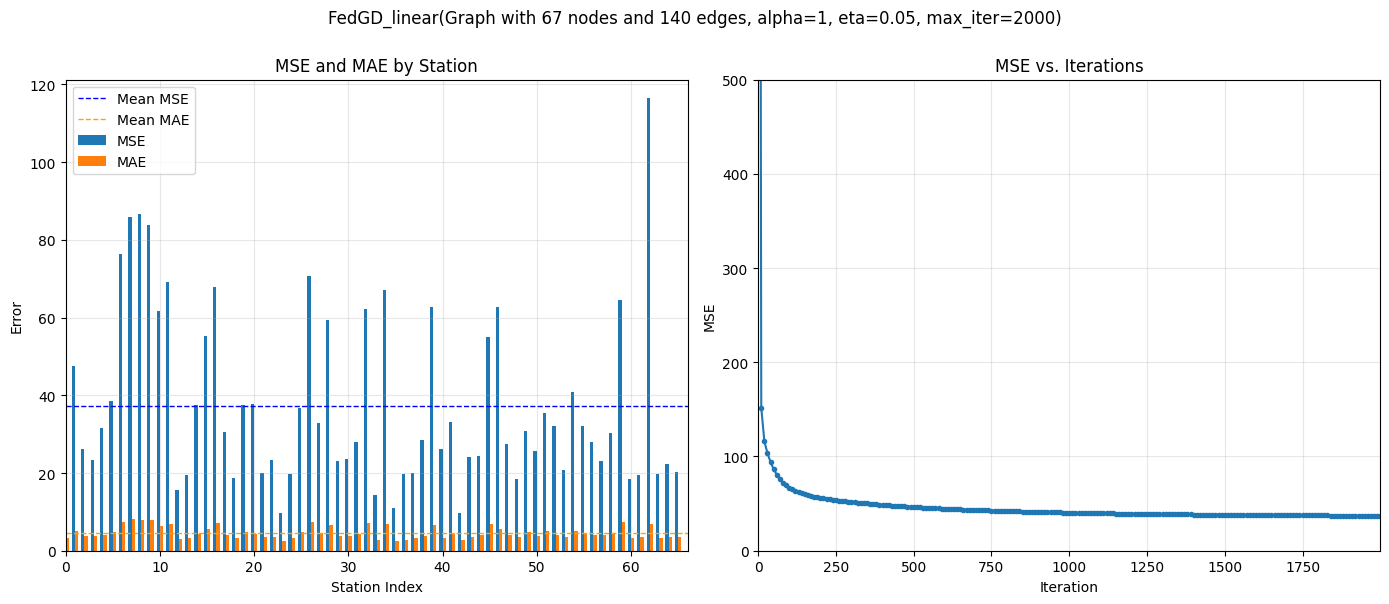

In [28]:
G_fedgd_G_LAeq_05, history = FedGD_Linear(
    G_LAeq,
    alpha=1,
    eta=0.05,
    max_iter=2000)

evaluate_and_visualize(G_fedgd_G_LAeq_05, history)

Mean MSE across all nodes: 46.03
Mean MAE across all nodes: 5.25
Node with the highest MSE: 34, MSE: 151.63


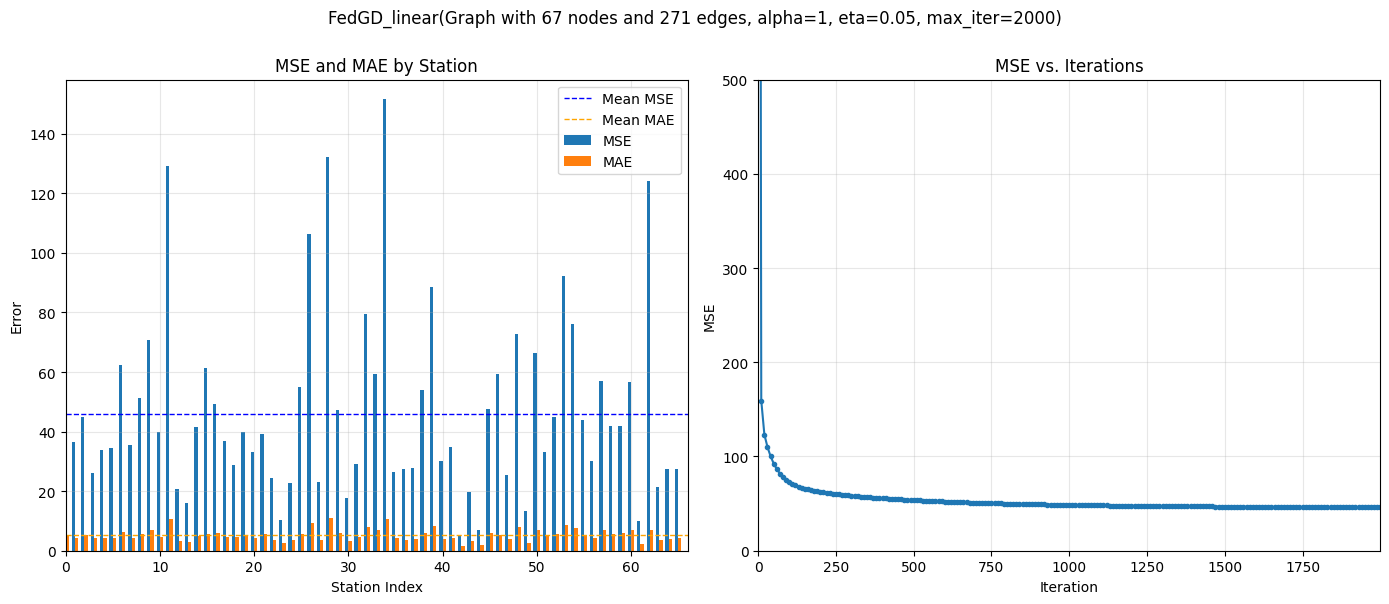

In [29]:
G_fedgd_G_Geo_05, history = FedGD_Linear(
    G_Geo,
    alpha=1,
    eta=0.05,
    max_iter=2000)

evaluate_and_visualize(G_fedgd_G_Geo_05, history)

Training for α = 0.0
Training for α = 0.1
Training for α = 0.2
Training for α = 0.3
Training for α = 0.4
Training for α = 0.5
Training for α = 0.6
Training for α = 0.7
Training for α = 0.8
Training for α = 0.9
Training for α = 1.0
Mean MSE: [np.float64(20.237262600663218), np.float64(23.905360767102497), np.float64(26.390468042874154), np.float64(28.514682812757805), np.float64(30.32576671659301), np.float64(31.87600027225103), np.float64(33.21348861360917), np.float64(34.37780491235785), np.float64(35.4003307675433), np.float64(36.30574501827476), np.float64(37.113511375867986)], Max MSE: [np.float64(96.23862254104765), np.float64(100.89515371769434), np.float64(104.36967975322777), np.float64(107.05588442892386), np.float64(109.20039381486504), np.float64(110.9505162203202), np.float64(112.40622017015042), np.float64(113.63718236847984), np.float64(114.69299274316474), np.float64(115.6096955500733), np.float64(116.41403214556465)], GTV: [np.float64(442.8628572377328), np.float64(25.2

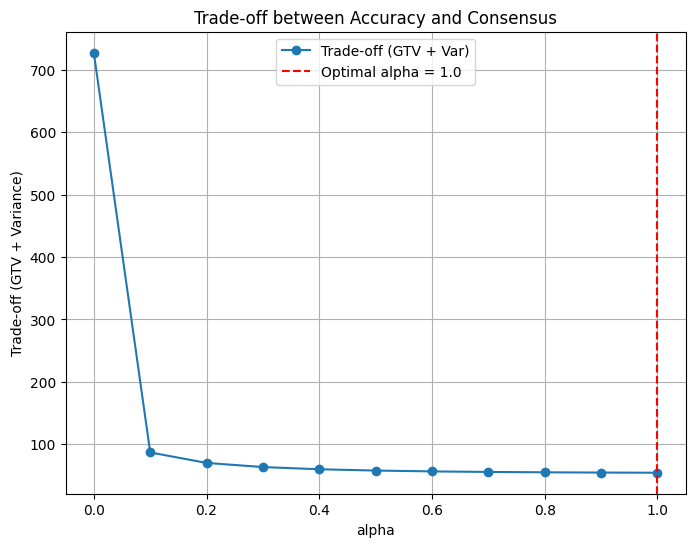

In [30]:
def compute_gtv_norm(G):
    s = sum(np.linalg.norm(G.nodes[i]['w'] - G.nodes[j]['w'])**2
            for i,j in G.edges())
    return s/ G.number_of_edges()

def compute_weight_variance(G):
    W = np.stack([G.nodes[i]['w'] for i in G.nodes()], axis=1)
    w_bar = W.mean(axis=1, keepdims=True)
    return float(np.mean(np.sum((W - w_bar)**2, axis=0)))

# Optimal alpha search
alphas = np.arange(0.0, 1.1, 0.1)
mean_mse_list = []
max_mse_list = []
gtv_list = []
var_w_list = []
trade_off = []

# You can adjust alpha, eta, max_iter to see the trade-off
for alpha in alphas:
    print(f"Training for α = {alpha:.1f}")

    G_alpha, history = FedGD_Linear(
        G_LAeq, 
        alpha=alpha, 
        eta=0.05, 
        max_iter=2000)
    
    # Evaluate MSE
    mse_list = []
    for node in G_alpha.nodes():
        X_val = G_alpha.nodes[node]['X_val']
        y_val = G_alpha.nodes[node]['y_val']
        w = G_alpha.nodes[node]['w']
        y_pred = X_val @ w
        mse = mean_squared_error(y_val, y_pred)
        mse_list.append(mse)
    
    mean_mse_list.append(np.mean(mse_list))
    max_mse_list.append(np.max(mse_list))
    
    # Evaluate consensus
    gtv = compute_gtv_norm(G_alpha)
    var_w = compute_weight_variance(G_alpha)
    gtv_list.append(gtv)
    var_w_list.append(var_w)
    
    # Trade-off score
    score = np.mean(mse_list) + gtv + var_w
    trade_off.append(score)    

print(f"Mean MSE: {mean_mse_list}, Max MSE: {max_mse_list}, GTV: {gtv_list}, Variance: {var_w_list}, Trade-off: {trade_off}") 

# Find the best alpha (minimum trade-off)
best_alpha = alphas[np.argmin(trade_off)]

# Plot Trade-off
plt.figure(figsize=(8, 6))
plt.plot(alphas, trade_off, marker='o', label='Trade-off (GTV + Var)')
plt.xlabel("alpha")
plt.ylabel("Trade-off (GTV + Variance)")
plt.title("Trade-off between Accuracy and Consensus")
best_alpha = alphas[np.argmin(trade_off)]
plt.axvline(best_alpha, color='r', linestyle='--', label=f'Optimal alpha = {best_alpha:.1f}')
plt.legend()
plt.grid()
plt.show()


alpha for fedgd_linear(G_LAeq, eta=0.05, max_iter=2000)
| α   | Mean MSE | Max MSE | GTV Norm | Var(w) | Trade-off | 
|-----|----------|---------|----------|--------|-----------|
| 0.0 | 20.24    | 96.24   | 442.86   | 264.31 | 727.41    |
| 0.1 | 23.91    | 100.90  | 25.20    | 37.91  | 87.01     |
| 0.2 | 26.39    | 104.37  | 15.76    | 28.06  | 70.21     |
| 0.3 | 28.51    | 107.06  | 11.28    | 23.78  | 63.57     |
| 0.4 | 30.33    | 109.20  | 8.63     | 21.11  | 60.06     |
| 0.5 | 31.88    | 110.95  | 6.88     | 19.20  | 57.96     |
| 0.6 | 33.21    | 112.41  | 5.66     | 17.75  | 56.63     |
| 0.7 | 34.38    | 113.64  | 4.76     | 16.61  | 55.75     |
| 0.8 | 35.40    | 114.69  | 4.08     | 15.68  | 55.17     |
| 0.9 | 36.31    | 115.61  | 3.55     | 14.91  | 54.77 |
| 1.0 | 37.11    | 116.41  | 3.13     | 14.26  | **54.50** ✅ |

alpha for fedgd_linear(G_LAeq, eta=0.1, max_iter=1000)
| α   | Mean MSE | Max MSE | GTV Norm | Var(w) | Trade-off |
|-----|----------|---------|----------|--------|-----------|
| 0.0 | 20.24    | 96.24   | 442.94   | 264.36 | 727.54    |
| 0.1 | 23.90    | 100.90  | 25.20    | 37.91  | 87.01     |
| 0.2 | 26.39    | 104.37  | 15.76    | 28.06  | 70.21     |
| 0.3 | 28.51    | 107.06  | 11.28    | 23.78  | 63.58     |
| 0.4 | 30.33    | 109.21  | 8.63     | 21.11  | 60.06     |
| 0.5 | 31.88    | 110.96  | 6.88     | 19.20  | 57.96     |
| 0.6 | 33.21    | 112.41  | 5.66     | 17.75  | 56.63     |
| 0.7 | 34.38    | 113.64  | 4.76     | 16.61  | 55.75     |
| 0.8 | 35.40    | 114.70  | 4.08     | 15.68  | 55.17     |
| 0.9 | 36.30    | 115.62  | 3.55     | 14.91  | **54.77** ✅ |
| 1.0 | 36.97    | 116.42  | 3.50     | 14.37  | 54.84     |

Highest MSE: 219.53

Mean MSE across all nodes (FedAvg manual): 54.3674
Mean MAE across all nodes (FedAvg manual): 5.7573


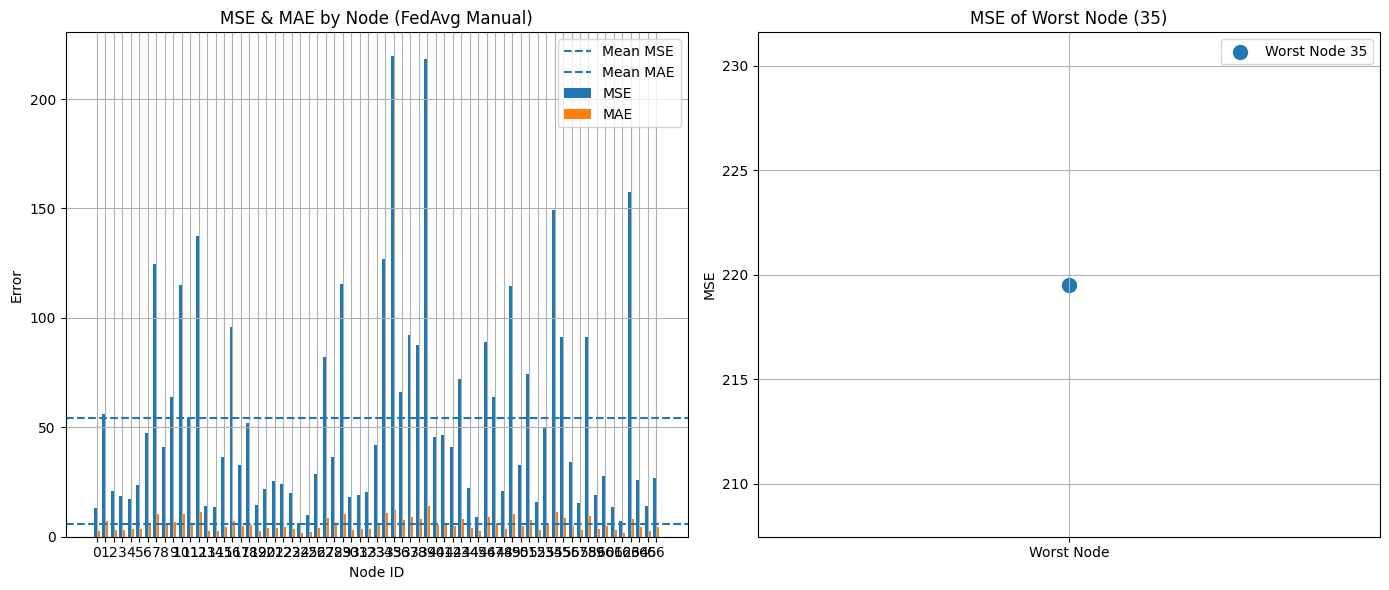

In [31]:
# FedAvg (Federated Averaging) with local evaluation
def FedAvg_linear(G, eta, max_iter, rounds):
    """
    FedAvg using manual gradient descent on each node.
    """
    results = {}
    mse_list = []
    mae_list = []

    # Global model initialization
    global_w = None
    global_b = 0.0

    for round_num in range(rounds):
        #print(f"\n--- Federation Round {round_num+1}/{rounds} ---")
        local_models = {}
        node_weights = {}

        for node_id in G.nodes():
            data = G.nodes[node_id]
            X = data["X_train"]
            y = data["y_train"]

            if len(X) == 0:
                print(f"Node {node_id}: Not enough training data.")
                continue

            n_features = X.shape[1]
            if global_w is None:
                global_w = np.zeros(n_features)
                global_b = 0.0

            # Copy global weights for local training
            w = global_w.copy()
            b = global_b

            # Manual gradient descent
            for _ in range(max_iter):
                y_hat = X.dot(w) + b
                error = y_hat - y
                grad_w = (2 / len(X)) * X.T.dot(error)
                grad_b = (2 / len(X)) * np.sum(error)
                w -= eta * grad_w
                b -= eta * grad_b

            # Save local model and its weight (number of samples)
            local_models[node_id] = {'w': w, 'b': b}
            node_weights[node_id] = len(X)

        if not local_models:
            print("Not enough data to train local models.")
            return {}

        # Normalize weights
        total_samples = sum(node_weights.values())
        for node_id in node_weights:
            node_weights[node_id] /= total_samples

        # FedAvg aggregation
        new_w = np.zeros_like(global_w)
        new_b = 0.0
        for node_id, model in local_models.items():
            weight = node_weights[node_id]
            new_w += weight * model['w']
            new_b += weight * model['b']

        global_w = new_w
        global_b = new_b

    # Evaluation
    for node_id in G.nodes():
        data = G.nodes[node_id]
        X_test = data["X_val"]
        y_test = data["y_val"]

        if len(X_test) == 0:
            print(f"Node {node_id}: Not enough test data.")
            continue

        y_pred = X_test.dot(global_w) + global_b
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)

        results[node_id] = {
            "mse": mse,
            "mae": mae,
            "num_test_samples": len(X_test),
            "eta": eta,
            "max_iter": max_iter
        }
        mse_list.append(mse)
        mae_list.append(mae)
    max_idx = np.argmax(mse_list)
    
    print(f"Highest MSE: {mse_list[max_idx]:.2f}")
    
    if not mse_list:
        print("Not enough data to evaluate any node.")
        return {}

    print(f"\nMean MSE across all nodes (FedAvg manual): {np.mean(mse_list):.4f}")
    print(f"Mean MAE across all nodes (FedAvg manual): {np.mean(mae_list):.4f}")

    # Quick visualization
    node_ids = list(results.keys())
    worst_node = node_ids[np.argmax(mse_list)]
    worst_mse = results[worst_node]['mse']

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    x = np.arange(len(node_ids))
    width = 0.35
    plt.bar(x - width/2, mse_list, width, label='MSE')
    plt.bar(x + width/2, mae_list, width, label='MAE')
    plt.axhline(np.mean(mse_list), linestyle='--', label='Mean MSE')
    plt.axhline(np.mean(mae_list), linestyle='--', label='Mean MAE')
    plt.xticks(x, node_ids)
    plt.xlabel('Node ID')
    plt.ylabel('Error')
    plt.title('MSE & MAE by Node (FedAvg Manual)')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.scatter([1], [worst_mse], s=100, label=f'Worst Node {worst_node}')
    plt.xlim(0.5, 1.5)
    plt.xticks([1], ['Worst Node'])
    plt.ylabel('MSE')
    plt.title(f'MSE of Worst Node ({worst_node})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save global model
    results["global_model"] = {'w': global_w, 'b': global_b}
    return results


# Function to make predictions with the global model
def predict_with_global_model(G, results, X_new=None):
    """
    Make predictions using the global model trained with manual FedAvg.

    Parameters:
    -----------
    G : networkx.Graph
        Graph with data per node.
    results : dict
        Training results, including the global model {'w': ..., 'b': ...}.
    X_new : ndarray, optional
        New data to predict. If None, X_val from each node is used.

    Returns:
    --------
    dict
        Dictionary with predictions per node.
    """
    predictions = {}

    # Retrieve the global model
    global_model = results.get("global_model", None)
    if global_model is None:
        print("Global model not found in results.")
        return {}

    w = global_model["w"]
    b = global_model["b"]

    for node_id in G.nodes():
        if X_new is None:
            X = G.nodes[node_id]["X_val"]
        else:
            X = X_new 

        if len(X) == 0:
            continue

        y_pred = X.dot(w) + b
        predictions[node_id] = y_pred

    return predictions


# Usage:
FedAvg_results = FedAvg_linear(
    G_LAeq, 
    eta=0.05, 
    max_iter=10, 
    rounds=200
    )
predicciones = predict_with_global_model(G_LAeq, FedAvg_results)

Highest MSE: 233.14

Mean MSE across all nodes: 54.0673
Mean MAE across all nodes: 5.7004

Global MSE on entire dataset: 53.3071
Global MAE on entire dataset: 5.7014


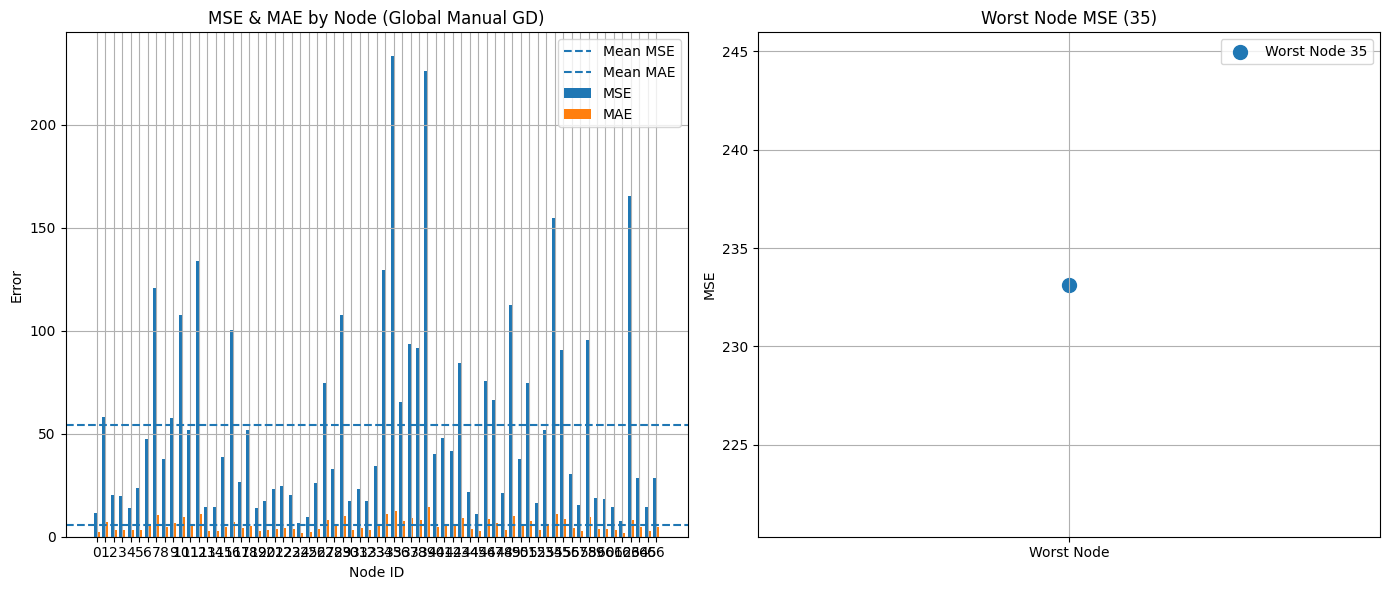

In [32]:
# Global model training with manual gradient descent and local evaluation

def train_global_predict_local(graph, eta, max_iter):
    """
    Trains a global linear model using manual gradient descent on all training data,
    then evaluates the global model's performance on each individual node.

    Parameters
    ----------
    graph : networkx.Graph
        Graph with nodes and their data.
    eta : float
        Learning rate for gradient updates.
    max_iter : int
        Number of gradient descent iterations.
    """
    # 1) Deep copy graph to avoid mutating original
    G = copy.deepcopy(graph)

    # 2) Combine all training data from nodes
    X_all, y_all = [], []
    for n in G.nodes():
        X_all.append(G.nodes[n]['X_train'])
        y_all.append(G.nodes[n]['y_train'])
    X_combined = np.vstack(X_all)
    y_combined = np.concatenate(y_all)

    # 3) Initialize global model parameters
    n_samples, n_features = X_combined.shape
    w = np.zeros(n_features)
    b = 0.0

    # 4) Manual gradient descent on combined data
    for _ in range(max_iter):
        y_pred = X_combined.dot(w) + b
        error = y_pred - y_combined
        # gradients
        grad_w = (2 / n_samples) * X_combined.T.dot(error)
        grad_b = (2 / n_samples) * np.sum(error)
        # parameter updates
        w -= eta * grad_w
        b -= eta * grad_b

    # 5) Evaluate global model per node
    results = {}
    mse_list, mae_list, node_ids = [], [], []
    for node_id in G.nodes():
        X_test = G.nodes[node_id]['X_val']
        y_test = G.nodes[node_id]['y_val']
        if X_test.size == 0:
            print(f"Node {node_id}: Not enough test data.")
            continue
        # predict
        y_pred_node = X_test.dot(w) + b
        mse = mean_squared_error(y_test, y_pred_node)
        mae = mean_absolute_error(y_test, y_pred_node)
        results[node_id] = {
            'mse': mse,
            'mae': mae,
            'num_test_samples': len(y_test)
        }
        node_ids.append(node_id)
        mse_list.append(mse)
        mae_list.append(mae)

    max_idx = np.argmax(mse_list)
    print(f"Highest MSE: {mse_list[max_idx]:.2f}")
    
    # 6) Print average metrics
    mean_mse = np.mean(mse_list)
    mean_mae = np.mean(mae_list)
    print(f"\nMean MSE across all nodes: {mean_mse:.4f}")
    print(f"Mean MAE across all nodes: {mean_mae:.4f}")

    # 7) Global metrics on combined validation data
    X_val_all, y_val_all = [], []
    for n in G.nodes():
        X_val_all.append(G.nodes[n]['X_val'])
        y_val_all.append(G.nodes[n]['y_val'])
    if X_val_all and y_val_all:
        X_val_comb = np.vstack(X_val_all)
        y_val_comb = np.concatenate(y_val_all)
        y_pred_comb = X_val_comb.dot(w) + b
        global_mse = mean_squared_error(y_val_comb, y_pred_comb)
        global_mae = mean_absolute_error(y_val_comb, y_pred_comb)
        print(f"\nGlobal MSE on entire dataset: {global_mse:.4f}")
        print(f"Global MAE on entire dataset: {global_mae:.4f}")

    # 8) Visualization
    worst_idx = np.argmax(mse_list)
    worst_node = node_ids[worst_idx]
    worst_mse = mse_list[worst_idx]

    plt.figure(figsize=(14, 6))
    # MSE & MAE per node
    plt.subplot(1, 2, 1)
    x = np.arange(len(node_ids))
    width = 0.35
    plt.bar(x - width/2, mse_list, width, label='MSE')
    plt.bar(x + width/2, mae_list, width, label='MAE')
    plt.axhline(mean_mse, linestyle='--', label='Mean MSE')
    plt.axhline(mean_mae, linestyle='--', label='Mean MAE')
    plt.xticks(x, node_ids)
    plt.xlabel('Node ID')
    plt.ylabel('Error')
    plt.title('MSE & MAE by Node (Global Manual GD)')
    plt.legend()
    plt.grid(True)

    # Worst node MSE
    plt.subplot(1, 2, 2)
    plt.scatter([1], [worst_mse], s=100, label=f'Worst Node {worst_node}')
    plt.xlim(0.5, 1.5)
    plt.xticks([1], ['Worst Node'])
    plt.ylabel('MSE')
    plt.title(f'Worst Node MSE ({worst_node})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 9) Save global params in graph nodes
    for node_id in G.nodes():
        G.nodes[node_id]['w_global'] = w.reshape(-1, 1)
        G.nodes[node_id]['b_global'] = b
        G.nodes[node_id]['eta'] = eta
        G.nodes[node_id]['max_iter'] = max_iter

    # History for compatibility
    history = {
        'iteration': list(range(1, max_iter+1)),
        'mse': [None] * max_iter  # no per-iteration tracking
    }

    return G, history, results


G_global, history_global, results_global = train_global_predict_local(
    G_LAeq, 
    eta=0.05, 
    max_iter=2000
    )



######### Comparison of MSE between the three different methods used ###########

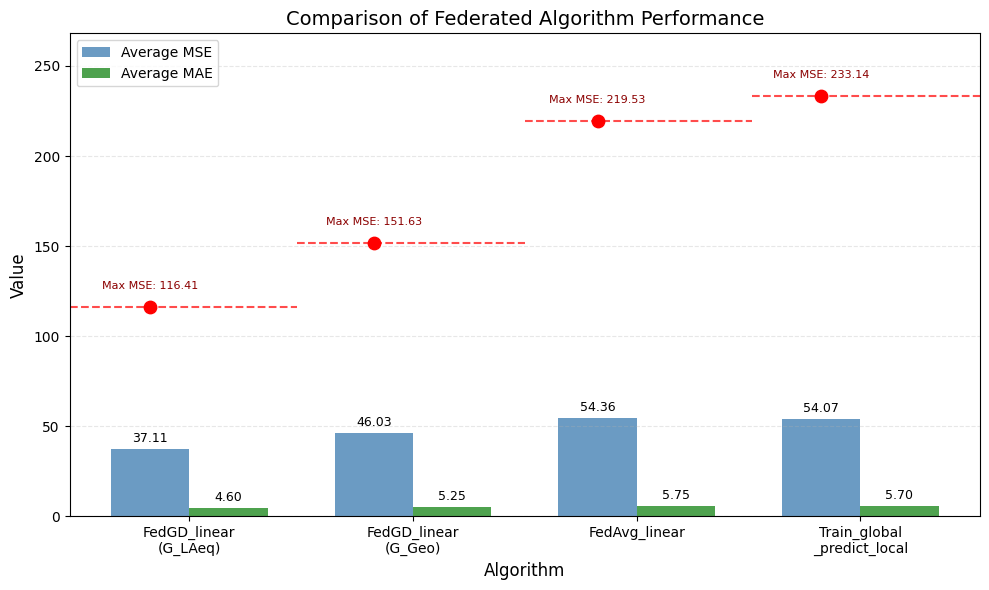

In [33]:
# Algorithm data
algorithms = ['FedGD_linear\n(G_LAeq)', 'FedGD_linear\n(G_Geo)', 'FedAvg_linear', 'Train_global\n_predict_local']

# MSE and MAE values for each algorithm
mse_values = [37.11, 46.03, 54.36, 54.07]
mae_values = [4.60, 5.25, 5.75, 5.70]

# Highest MSE values for each algorithm
highest_mse = [116.41, 151.63, 219.53, 233.14]

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Configure bar positions
x = np.arange(len(algorithms))
width = 0.35

# Create bars for MSE
mse_bars = ax.bar(x - width/2, mse_values, width, label='Average MSE', color='steelblue', alpha=0.8)

# Create bars for MAE
mae_bars = ax.bar(x + width/2, mae_values, width, label='Average MAE', color='forestgreen', alpha=0.8)

# Add labels to the bars
ax.bar_label(mse_bars, fmt='%.2f', padding=3, fontsize=9)
ax.bar_label(mae_bars, fmt='%.2f', padding=3, fontsize=9)

# Add dashed lines for the highest MSE of each algorithm
for i, val in enumerate(highest_mse):
    # Dashed line for the highest MSE
    ax.axhline(y=val, xmin=(i/len(algorithms)), xmax=((i+1)/len(algorithms)), 
              color='red', linestyle='--', alpha=0.7)
    
    # Add point for the highest MSE
    ax.scatter(x[i] - width/2, val, color='red', s=80, zorder=3, marker='o')
    
    # Add label for the highest MSE
    ax.annotate(f'Max MSE: {val:.2f}', 
               xy=(x[i] - width/2, val), 
               xytext=(x[i] - width/2, val + 10),
               fontsize=8,
               color='darkred',
               ha='center')

# Configure labels and title
ax.set_xlabel('Algorithm', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.set_title('Comparison of Federated Algorithm Performance', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(algorithms)
ax.legend(loc='upper left')

# Adjust y-axis limits to show all lines and points
ax.set_ylim(0, max(highest_mse) * 1.15)

# Add grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()